In [1]:
import requests
import numpy as np

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print (names)

/tmp/ipykernel_1657/1317417187.py:10: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [2]:
# Find column index
idx_time = np.where(names == 'T90')[0][0]
idx_fluence = np.where(names == 'fluence')[0][0]
#idx_redshift = np.where(names == 'redshift')[0][0] WE WILL NOT USE REDSHIFT BECAUSE IT'S MOST UKNOWN

# Extract columns
time = data[idx_time].astype(float)
fluence = data[idx_fluence].astype(float)
#redshift = data[idx_redshift].astype(float)

# Build dataset (one row per event, 2 columns, we dont need the corresponding errors)
new_dataset = np.column_stack((time, fluence)) #, redshift))

print("Shape:", new_dataset.shape)
for i in range(10):
    print(new_dataset[i]) #check for unacceptable values


Shape: (8724, 2)
[1.8173e+01 3.4854e-06]
[5.6320e+00 7.6139e-07]
[-999. -999.]
[-999. -999.]
[1.0240e+01 2.5096e-06]
[-999. -999.]
[-999. -999.]
[2.2784e+01 3.8016e-05]
[1.1008e+01 1.1293e-06]
[2.68805e+02 1.77340e-05]


In [3]:
#cleaning process
mask = np.all((new_dataset > -1) & (~np.isnan(new_dataset)) & (new_dataset != 0), axis=1)
clean_dataset = new_dataset[mask]

print("Shape:", clean_dataset.shape)
for i in range(10):
    print(clean_dataset[i])

Shape: (7476, 2)
[1.8173e+01 3.4854e-06]
[5.6320e+00 7.6139e-07]
[1.0240e+01 2.5096e-06]
[2.2784e+01 3.8016e-05]
[1.1008e+01 1.1293e-06]
[2.68805e+02 1.77340e-05]
[6.2720e+00 4.5797e-05]
[6.0672e+01 2.0956e-06]
[2.0992e+01 5.9394e-06]
[9.1394e+01 3.4568e-05]


In [4]:
from astroML import stats as astroMLstats

def bins_num (X) :

    sigmaG2 = astroMLstats.sigmaG(X) # quantile at 75 - quantile at 25
    binsize = 2.7 * sigmaG2 / (len(X)**(1/3)) #Freedman-Diaconis
    N = (max(X) - min(X))/binsize

    return int(N+2)

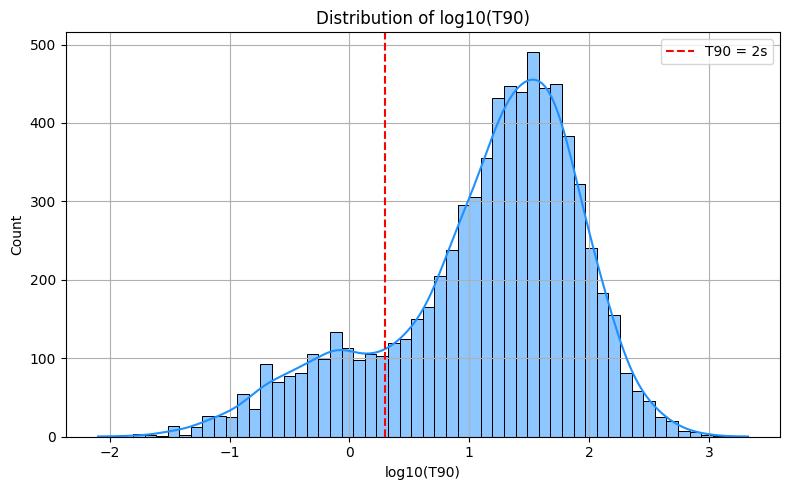

/tmp/ipykernel_1657/2945944980.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


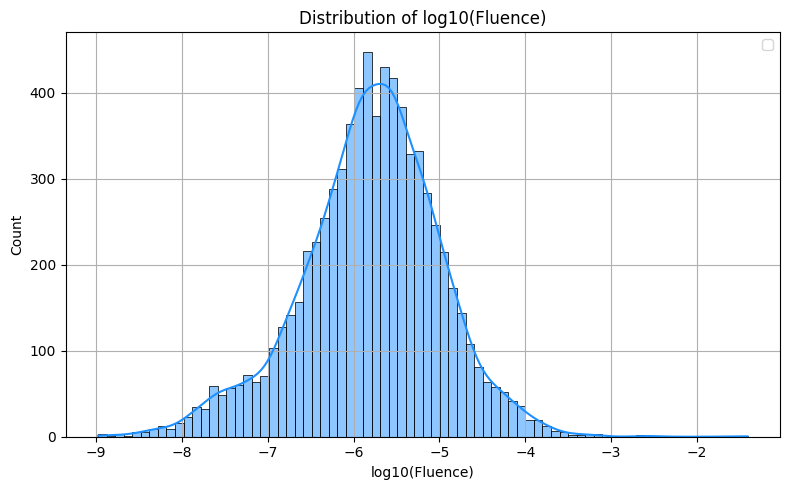

'"    it doesn\'t show multimodality \nplt.figure(figsize=(8,5))\nsns.histplot(redshift, bins = bins_num(redshift), kde=True, color=\'dodgerblue\') \nplt.xlabel("Redshift")\nplt.ylabel("Count")\nplt.title("Distribution of Redshift")\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n\n'

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

logT90 = np.log10(clean_dataset[:, 0])  # the astrophysicist love everything in log10 
logFluence = np.log10(clean_dataset[:, 1])  
#redshift = clean_dataset[:, 2] 

plt.figure(figsize=(8,5))   #it shows multimodality
sns.histplot(logT90, bins = bins_num(logT90), kde=True, color='dodgerblue') #seaborn has inside the KDE function
plt.xlabel("log10(T90)")
plt.ylabel("Count")
plt.title("Distribution of log10(T90)")
plt.axvline(np.log10(2), color='red', linestyle='--', label="T90 = 2s") # Discrimination time between short and long GRBs
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5)) #it shows a slight multimodality
sns.histplot(logFluence, bins = bins_num(logFluence), kde=True, color='dodgerblue') 
plt.xlabel("log10(Fluence)")
plt.ylabel("Count")
plt.title("Distribution of log10(Fluence)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

""""    it doesn't show multimodality 
plt.figure(figsize=(8,5))
sns.histplot(redshift, bins = bins_num(redshift), kde=True, color='dodgerblue') 
plt.xlabel("Redshift")
plt.ylabel("Count")
plt.title("Distribution of Redshift")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

"""

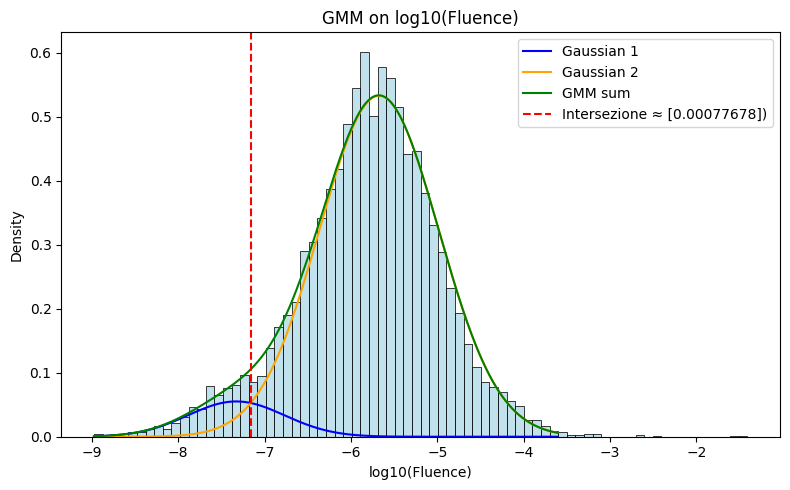

In [6]:
#Try to find the threshold in fluence 

from sklearn.mixture import GaussianMixture
from scipy.stats import norm

X = logFluence.reshape(-1, 1)

means_init = np.array([[-8], [np.median(X)]]) #starting point for one of the gaussian

gmm = GaussianMixture(n_components=2 , means_init=means_init,random_state=0).fit(X)

means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_).flatten()
weights = gmm.weights_


# Find the intersection point between the two gaussian
x = np.linspace(min(X), max(X)-2.2, 1000) #have to put max - 2.2 because in the other case the two gaussian will intersec always at max
pdf1 = weights[0] * norm.pdf(x, means[0], stds[0])
pdf2 = weights[1] * norm.pdf(x, means[1], stds[1])
diff = np.abs(pdf1 - pdf2)
min_idx = np.argmin(diff)
intersection = x[min_idx]

pdf_total = pdf1 + pdf2

plt.figure(figsize=(8,5))
sns.histplot(logFluence, bins = bins_num(logFluence), kde=False, color='lightblue', stat='density')
plt.plot(x, pdf1, color='blue', label='Gaussian 1')
plt.plot(x, pdf2, color='orange', label='Gaussian 2')
plt.plot(x, pdf_total, color='green', linestyle='-', label='GMM sum')
plt.axvline(intersection, color='red', linestyle='--', label=f'Intersezione ≈ {np.exp(intersection)})')
plt.xlabel("log10(Fluence)")
plt.ylabel("Density")
plt.title("GMM on log10(Fluence)")
plt.legend()
plt.tight_layout()
plt.show()

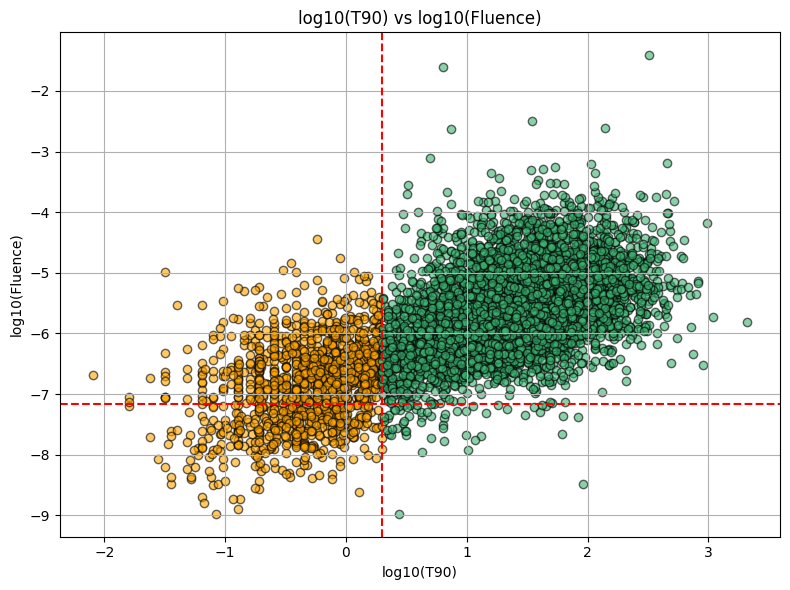

In [7]:
plt.figure(figsize=(8,6))

# Create a mask for points with T90 < 2
mask = logT90 < np.log10(2)

# Points with T90 < 2 (colored orange)
plt.scatter(logT90[mask], logFluence[mask], alpha=0.6, edgecolors='k', c='orange', label='T90 < 2s')

# Points with T90 ≥ 2 (colored mediumseagreen)
plt.scatter(logT90[~mask], logFluence[~mask], alpha=0.6, edgecolors='k', c='mediumseagreen', label='T90 ≥ 2s')

plt.xlabel("log10(T90)")
plt.ylabel("log10(Fluence)")
plt.title("log10(T90) vs log10(Fluence)")
plt.grid(True)
plt.axhline(intersection, color='red', linestyle='--', label=f'Intersection ≈ {np.exp(intersection)})')
plt.axvline(np.log10(2), color='red', linestyle='--', label="T90 = 2s")
plt.tight_layout()
plt.show()



In [8]:
# KMeans try to "fit" the chosen number of cluster to the data

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

X = np.column_stack((logT90, logFluence))

for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=0).fit(X)
    
    # Silhouette score measures how well-separated and cohesive the clusters are:
    # values close to 1 indicate well-defined clusters, near 0 indicate overlapping,
    # and negative values suggest misclassified points.
    s = silhouette_score(X, km.labels_)
    
    print("silhouette_score with", k, "clusters:", s, "\n")


silhouette_score with 2 clusters: 0.5160721519428803 

silhouette_score with 3 clusters: 0.3855141518823896 

silhouette_score with 4 clusters: 0.3398991432997257 

silhouette_score with 5 clusters: 0.31925276930311297 

silhouette_score with 6 clusters: 0.3215602846378036 

silhouette_score with 7 clusters: 0.3208184401258769 

silhouette_score with 8 clusters: 0.3136608298201772 

silhouette_score with 9 clusters: 0.3197427529416868 



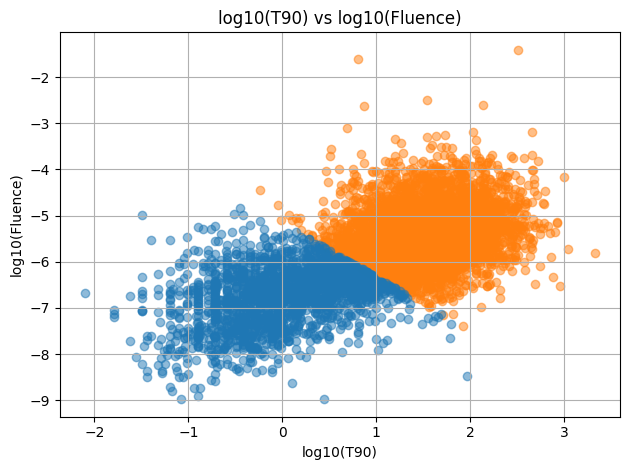

In [9]:

clf = KMeans(n_clusters=2, n_init='auto') #2 cluster is the best
clf.fit(X)
labels = clf.predict(X) #labels for each of the points

# plot the data color-coded by cluster id
colors = ['C1', 'C0']
plt.scatter(X[labels==0,0], X[labels==0,1], color=colors[0],alpha=0.5)
plt.scatter(X[labels==1,0], X[labels==1,1], color=colors[1],alpha=0.5)

plt.xlabel("log10(T90)")
plt.ylabel("log10(Fluence)")
plt.title("log10(T90) vs log10(Fluence)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Compute the Mean-shift clustering, which is a non-parametric clustering algorithm
# it does not require the number of clusters to be specified in advance, because it finds the best number of clusters based on the data

from sklearn.cluster import MeanShift

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# here the problem is that the bandwidth is not known
# the bandwidth is a parameter that defines the size of the region around each point
# in which the algorithm will search for points to form a cluster

for i in range(1, 20):
    ms = MeanShift(bandwidth=i/10, bin_seeding=True, cluster_all=False)
    ms.fit(X_scaled)
    s = silhouette_score(X_scaled, ms.labels_)
    print("silhouette_score con " , i/10 , " di banwidth: ", s, "\n")
    

silhouette_score con  0.1  di banwidth:  0.1764214365825404 

silhouette_score con  0.2  di banwidth:  -0.12335578917469925 

silhouette_score con  0.3  di banwidth:  -0.25483999857586076 

silhouette_score con  0.4  di banwidth:  -0.232416324824633 

silhouette_score con  0.5  di banwidth:  -0.13834106154932307 

silhouette_score con  0.6  di banwidth:  -0.023926857817437697 

silhouette_score con  0.7  di banwidth:  0.08826165101366239 

silhouette_score con  0.8  di banwidth:  0.151631474900688 

silhouette_score con  0.9  di banwidth:  0.21722304664316983 

silhouette_score con  1.0  di banwidth:  0.27530191032676804 

silhouette_score con  1.1  di banwidth:  0.3247581790343232 

silhouette_score con  1.2  di banwidth:  0.3634317563573889 

silhouette_score con  1.3  di banwidth:  0.4051761021761956 

silhouette_score con  1.4  di banwidth:  0.4316391234320154 

silhouette_score con  1.5  di banwidth:  0.4548902488782716 

silhouette_score con  1.6  di banwidth:  0.473322784355456 

number of estimated clusters: 6


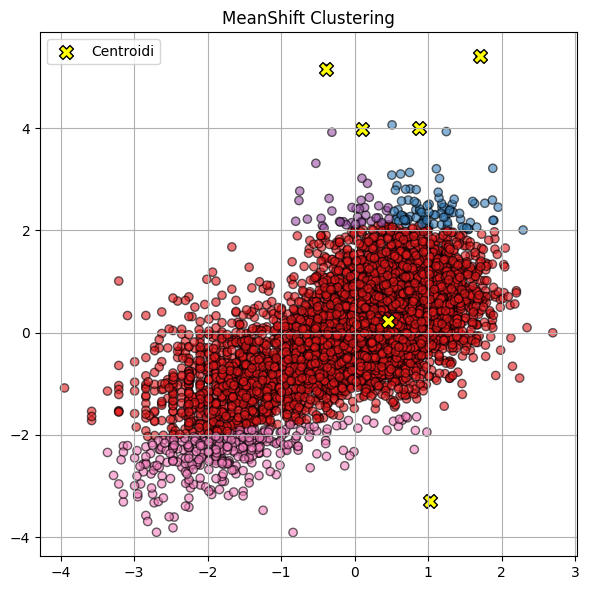

In [14]:
# we cant say nothing better that the best banwidth is upper than 0.7

ms = MeanShift(bandwidth= 0.7 , bin_seeding=True, cluster_all=True)
# if i put cluster_all = False, it will  assign a label (-1) to the points that are not in any cluster
ms.fit(X_scaled)

labels_ms = ms.labels_
centers_ms = ms.cluster_centers_

# Number of estimated cluster 
labels_unique = np.unique(labels_ms)
n_clusters = len(labels_unique[labels_unique >= 0]) #if ther's point with labebl -1, they are not counted
print("number of estimated clusters:", n_clusters)

# Plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()

# Scatter of the point  with different color for each cluster
scatter = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_ms, cmap='Set1', alpha=0.6, edgecolors='k')

# Scatter of the centroids
ax.scatter(centers_ms[:, 0], centers_ms[:, 1], s=100, c='yellow', edgecolors='black', marker='X', label='Centroidi')

ax.set_title('MeanShift Clustering')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


we can see an important thing about the outliars here:
- In KMeans algorithm, we are searching for a number of cluster chosen by us, the ouliars are irrelevant, it's the main set of data that determine everything
- In MeanShift if a point is far away from the other point will became a cluster it self, that's because the algorithm find the mean of a cluster and connect all the point that are under the correct lenght